## Time Series Coding
### Kanupriya Parashar

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.reset_option('all')

In [3]:
#importing data from FRED
df1=pd.read_csv("GDPCTPI.csv")
df2=pd.read_csv("UNRATE.csv")
df3=pd.read_csv("DFF.csv")

In [4]:
df1.head(100)

,DATE,GDPCTPI
0,1960-01-01,15.402
1,1960-04-01,15.457
2,1960-07-01,15.524
3,1960-10-01,15.592
4,1961-01-01,15.610
...,...,...
95,1983-10-01,48.151
96,1984-01-01,48.626
97,1984-04-01,49.063
98,1984-07-01,49.506


In [5]:
df2.head(100)

,DATE,UNRATE
0,1960-01-01,5.133333
1,1960-04-01,5.233333
2,1960-07-01,5.533333
3,1960-10-01,6.266667
4,1961-01-01,6.800000
...,...,...
95,1983-10-01,8.533333
96,1984-01-01,7.866667
97,1984-04-01,7.433333
98,1984-07-01,7.433333


In [6]:
#merging three data sets into one dataframe 
dt=pd.merge(df1,df2, on='DATE', how='inner')
dt=pd.merge(dt,df3, on='DATE', how='inner')

In [7]:
dt

,DATE,GDPCTPI,UNRATE,DFF
0,1960-01-01,15.402,5.133333,3.931319
1,1960-04-01,15.457,5.233333,3.695055
2,1960-07-01,15.524,5.533333,2.937500
3,1960-10-01,15.592,6.266667,2.296196
4,1961-01-01,15.610,6.800000,1.987556
...,...,...,...,...
248,2022-01-01,115.182,3.800000,0.121444
249,2022-04-01,117.704,3.600000,0.766813
250,2022-07-01,118.980,3.566667,2.182935
251,2022-10-01,120.115,3.600000,3.653370


In [8]:
#calculating inflation
dt['inflation']= 400*np.log(dt["GDPCTPI"]/dt["GDPCTPI"].shift(1))
dt["inflation"].dropna()

1      1.425842
2      1.730095
3      1.748299
4      0.461509
5      0.793575
         ...   
248    8.153238
249    8.663805
250    4.312965
251    3.797682
252    3.808148
Name: inflation, Length: 252, dtype: float64

## AR forecast

In [9]:
#converting the DATE column into a Datetime object
dt["DATE"]=pd.to_datetime(dt["DATE"])

In [10]:
#setting the date column as the index
dt.set_index(dt["DATE"],inplace=True)
if 'DATE' in dt.columns:
    dt.drop(columns=['DATE'], inplace=True)

In [11]:
#dropping NA values from the dataframe
dt.dropna(inplace=True)

In [12]:
dt.head()

,GDPCTPI,UNRATE,DFF,inflation
DATE,,,,
1960-04-01,15.457,5.233333,3.695055,1.425842
1960-07-01,15.524,5.533333,2.937500,1.730095
1960-10-01,15.592,6.266667,2.296196,1.748299
1961-01-01,15.610,6.800000,1.987556,0.461509
1961-04-01,15.641,7.000000,1.733516,0.793575


In [13]:
#splitting dataset into training and testing data set
training_set=dt.loc["1960-01-01":"2009-12-31"]
testing_set=dt.loc["2010-01-01":"2023-01-01"]

In [14]:
training_set.head()

,GDPCTPI,UNRATE,DFF,inflation
DATE,,,,
1960-04-01,15.457,5.233333,3.695055,1.425842
1960-07-01,15.524,5.533333,2.937500,1.730095
1960-10-01,15.592,6.266667,2.296196,1.748299
1961-01-01,15.610,6.800000,1.987556,0.461509
1961-04-01,15.641,7.000000,1.733516,0.793575


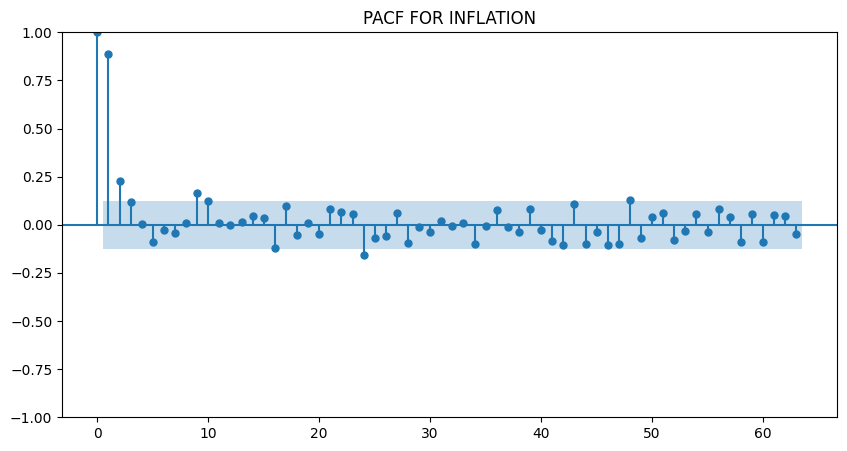

In [142]:
#PACF plotting 
fig,ax=plt.subplots(figsize=(10,5))
plot_pacf(dt["inflation"],ax=ax,lags=63,title="PACF FOR INFLATION");
plt.show();

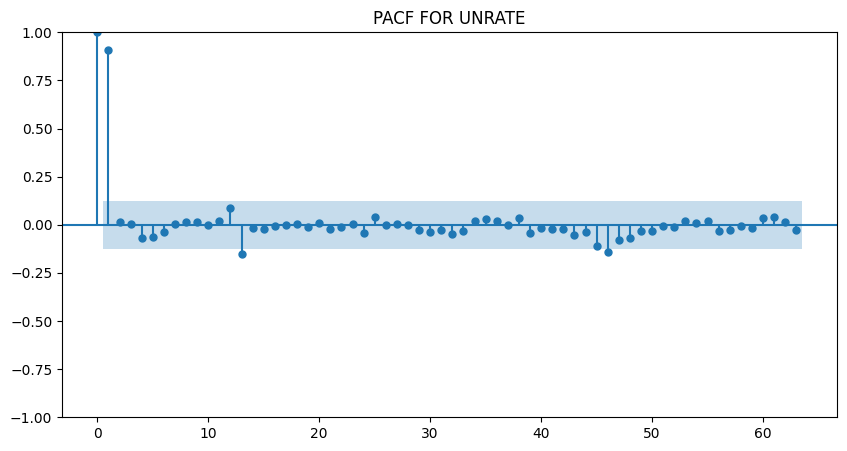

In [143]:
fig,ax=plt.subplots(figsize=(10,5))
plot_pacf(dt["UNRATE"],ax=ax,lags=63,title="PACF FOR UNRATE")
plt.show()

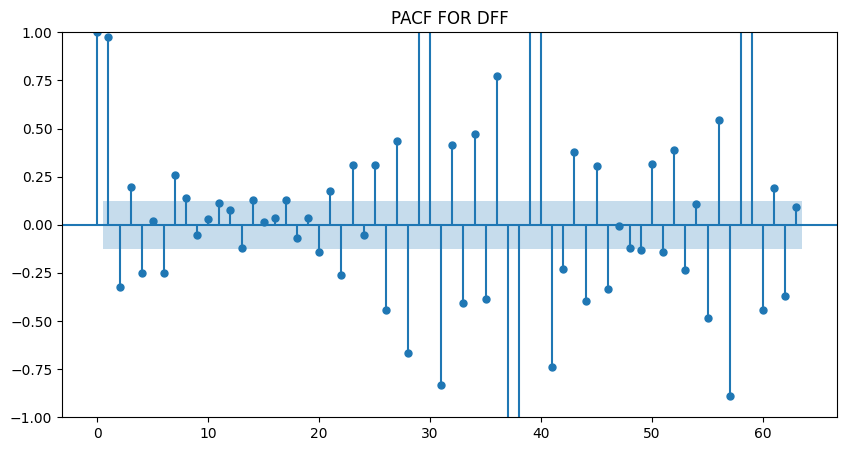

In [144]:
fig,ax=plt.subplots(figsize=(10,5))
plot_pacf(dt["DFF"],ax=ax,lags=63,title="PACF FOR DFF")
plt.show()

The PACF plot for GDPCTPI shows that there is only one significant lag value at lag =1, showing a positive correlation between GDPCTPI and its own lagged value. 
The PACF plot for Unemployment Rate shows one singificant positive partial autocorrelation and two significant negative partial autocorrelation, showing that there is a positve correlation between unemployment and its lagged value by 1, and there is a negative correlation between the unemployment rate and its lagged value at 11 and 46.
The PACF plot for Federal Funds Rate shows several sigificant partial autocorrelation, between Federal Funds Rate and its lagged value. It shows that at several lagged values, the Feceral Funds Rate shows both positive and negative correlation with its lagged values. 

In [145]:
#AR SELECT ORDER METHOD TO EVALUATE OPTIMAL LAG VALUES
order1=ar_select_order(dt["inflation"],maxlag=63, old_names=False)
optimal_order1=order1.ar_lags
model1=AutoReg(dt["GDPCTPI"],lags=optimal_order1)
result1=model1.fit

/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [146]:
optimal_order1

[1, 2]

In [147]:
order2=ar_select_order(dt["UNRATE"],maxlag=63, old_names=False)
optimal_order2=order2.ar_lags
model2=AutoReg(dt["UNRATE"],lags=optimal_order2)
result2=model2.fit
optimal_order2

/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


[1]

In [148]:
order3=ar_select_order(dt["DFF"],maxlag=63, old_names=False)
optimal_order3=order3.ar_lags
model3=AutoReg(dt["DFF"],lags=optimal_order3)
result3=model3.fit
optimal_order3

/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


[1, 2]

The results from the ar_select_order method produces almost a similar result for Inflation and UNRATE but it produces different results for Federal Funds Rate. 

/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


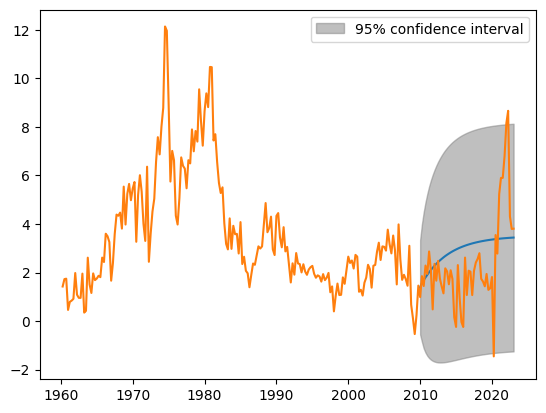

In [149]:
#Estimating on training data and forecast on testing data
model4 = AutoReg(training_set['inflation'],lags=[1, 2])
model_fit1 = model4.fit()
forecast1 = model_fit1.predict(start='2010',end='2023')
model_fit1.plot_predict(start='2010',end='2023');
plt.plot(dt["inflation"]['1960':'2023'])

Here the forecast matches our data till the year 2020 but from 2020 onwards, the forecast failed to match the data this could possibly be because of the macroeconomic shock like the COVID-19 pandemic which led to increase in the error term. 

/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


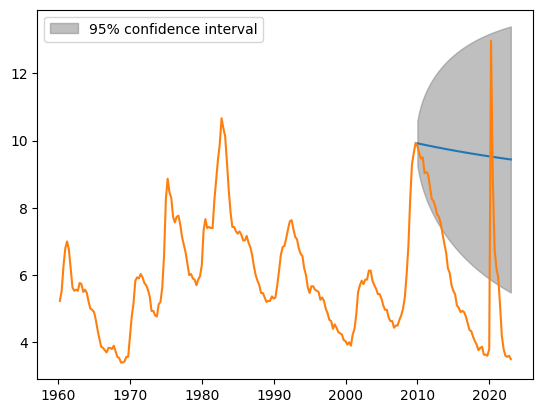

In [150]:
#Estimating on training data and forecast on testing data
model5 = AutoReg(training_set['UNRATE'],lags=[1])
model_fit2 = model5.fit()
forecast2 = model_fit2.predict(start='2010',end='2023')
model_fit2.plot_predict(start='2010',end='2023');
plt.plot(dt["UNRATE"]['1960':'2023'])

The forecast here as well doesn't match our data from 2010 onwards, this could potentially be due to the extension of the Great Recession effects as well as the COVID-19 pandemic, which both were macroeconomic shocks leading to an icnrease in the error term when forecasting unemployment rate. 

/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


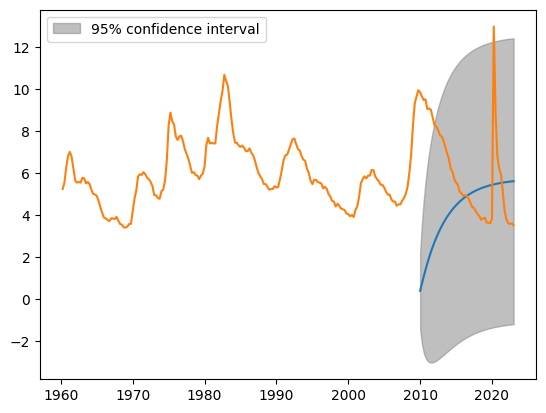

In [151]:
#Estimating on training data and forecast on testing data
model6 = AutoReg(training_set['DFF'],lags=[1,2])
model_fit3 = model6.fit()
forecast3 = model_fit3.predict(start='2010',end='2023')
model_fit3.plot_predict(start='2010',end='2023');
plt.plot(dt["UNRATE"]['1960':'2023'])

Here the forecast doesn't match with the data as well for the Federal Funds Rate for intial period, wherethe funds rate is decreasing while it increases as per our forecast, and then in 2023, it increases, while the Fed decreases the funds rate, even close to zero during the pandemic to stimualte borrowing and spending.

/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


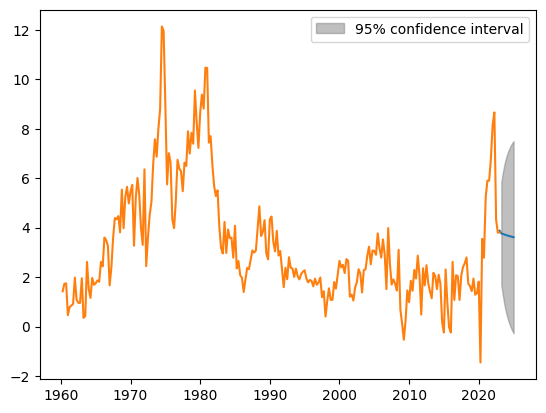

In [152]:
#forecasting 2 years ahead
#Estimating on training data and forecast on testing data
model7 = AutoReg(dt["inflation"],lags=[1,2])
model_fit4 = model7.fit()
forecast4 = model_fit4.predict(start='2023',end='2025')
model_fit4.plot_predict(start='2023',end='2025');
plt.plot(dt["inflation"]['1960':'2023'])

The forecast shows that in the next two years, the inflation will decrease.

/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


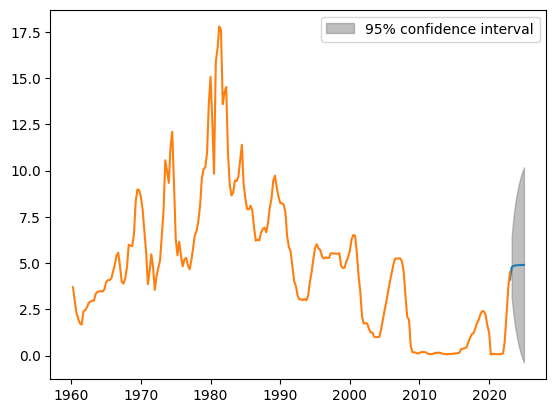

In [153]:
model8 = AutoReg(dt["DFF"],lags=[1,2])
model_fit5 = model8.fit()
forecast5 = model_fit5.predict(start='2023',end='2025')
model_fit5.plot_predict(start='2023',end='2025');
plt.plot(dt["DFF"]['1960':'2023'])

The forecast shows that in next two years the Fed will increase the funds rate and keep it stable. Indicating a future policy prediction of the Fed, showing they will keep the rates unchanged. This is also in cognizance to the recent communications by the Fed where they show their interest to keep the funds rate unchnaged in future. 

/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


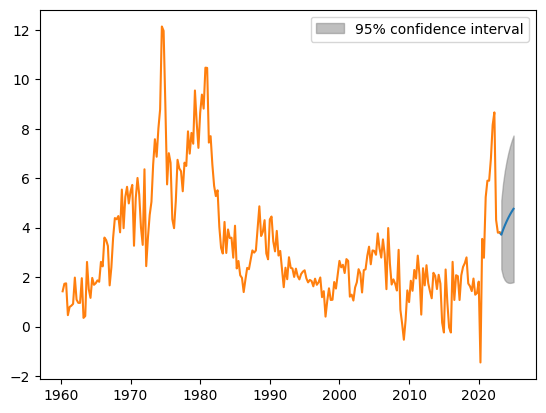

In [154]:
model9 = AutoReg(dt["UNRATE"],lags=[1])
model_fit6 = model9.fit()
forecast6 = model_fit6.predict(start='2023',end='2025')
model_fit6.plot_predict(start='2023',end='2025');
plt.plot(dt["inflation"]['1960':'2023'])

The forecast for the next two years show that the unemployment rate will increase from its last position in 2023. 

In [155]:
#VAR model for 1960-2000, replicating Stock and Watson (2001)
dt_var=dt["1960":"2000"]

In [156]:
dt_var=dt_var.drop(columns=["GDPCTPI"])

In [157]:
dt_var.tail()

,UNRATE,DFF,inflation
DATE,,,
1999-10-01,4.066667,5.304022,2.095419
2000-01-01,4.033333,5.677692,2.656670
2000-04-01,3.933333,6.271978,2.396426
2000-07-01,4.000000,6.519457,2.497327
2000-10-01,3.900000,6.474891,2.165626


/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


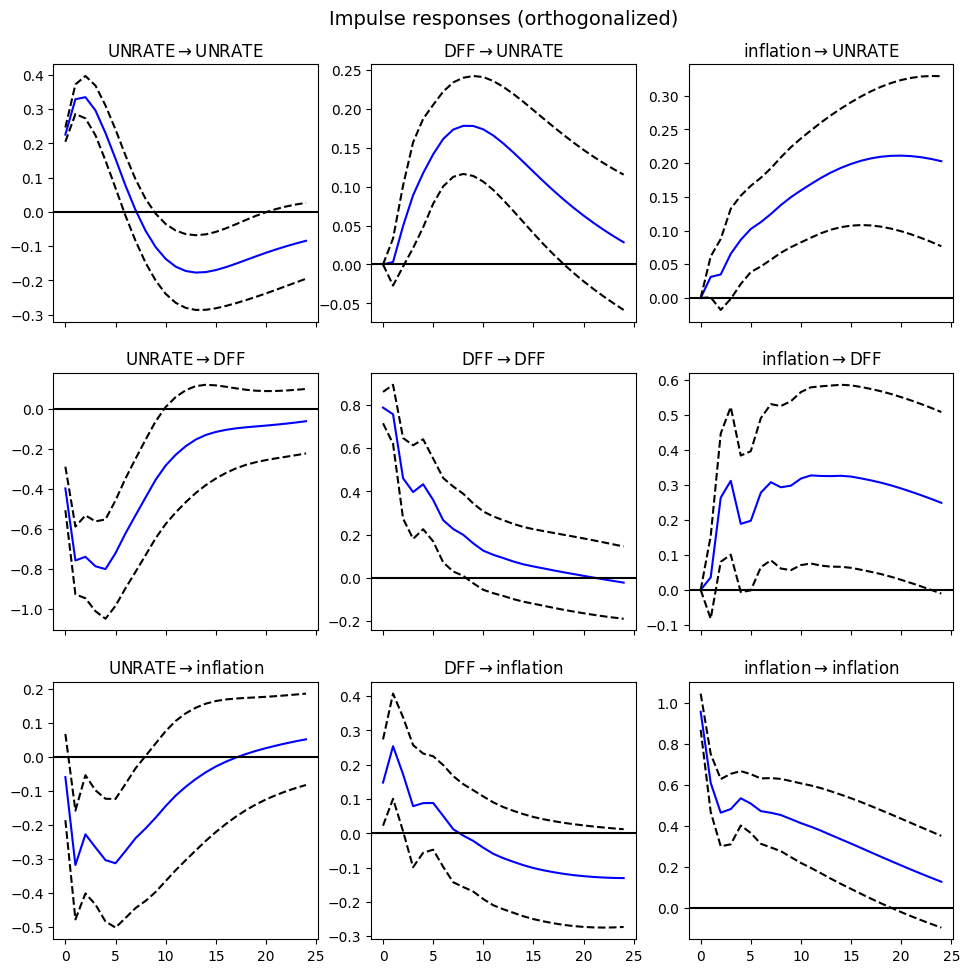

In [158]:
model_var = VAR(dt_var)
results_var = model_var.fit(4)
irf = results_var.irf(24)
fig = irf.plot(orth=True,signif=0.1)

In [161]:
#Factor Error Variance Decomposition for the above VAR model
fevd = results_var.fevd(12)
fevd.summary()

FEVD for UNRATE
        UNRATE       DFF  inflation
0     1.000000  0.000000   0.000000
1     0.993830  0.000063   0.006107
2     0.983195  0.008868   0.007937
3     0.955210  0.027571   0.017218
4     0.915542  0.053557   0.030901
5     0.864311  0.087386   0.048302
6     0.805030  0.127561   0.067409
7     0.743490  0.168207   0.088303
8     0.686625  0.203120   0.110256
9     0.639296  0.229092   0.131612
10    0.602833  0.245678   0.151488
11    0.575681  0.254184   0.170135

FEVD for DFF
        UNRATE       DFF  inflation
0     0.203827  0.796173   0.000000
1     0.381119  0.618225   0.000656
2     0.465429  0.508969   0.025602
3     0.524260  0.429629   0.046111
4     0.566355  0.388516   0.045129
5     0.591558  0.361815   0.046627
6     0.603929  0.340356   0.055714
7     0.607902  0.324913   0.067185
8     0.608021  0.314880   0.077099
9     0.605059  0.307417   0.087524
10    0.599426  0.300933   0.099641
11    0.592410  0.295276   0.112315

FEVD for inflation
        UNRATE

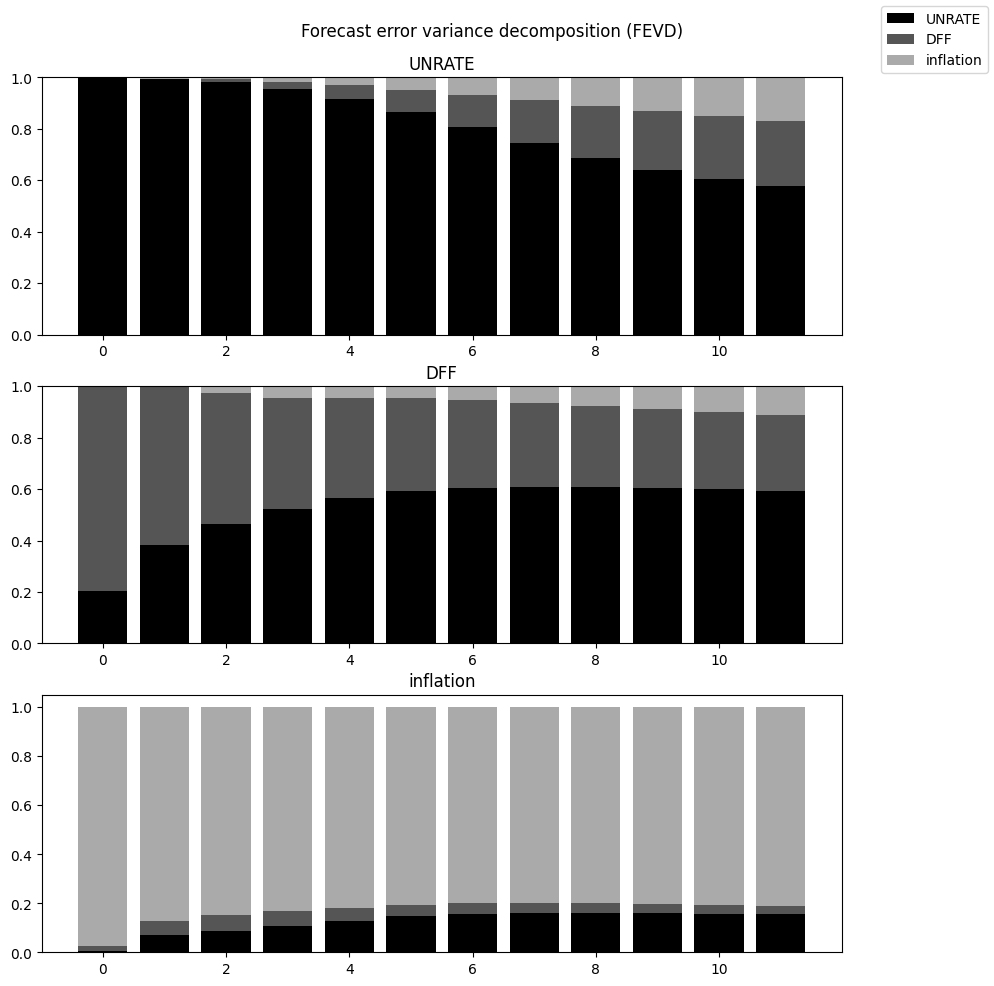

In [160]:
fevd.plot();

Testing for Granger Causality amongst variables and comparing to the results in Stock and Watson (2001)

In [162]:
results_var.test_causality('UNRATE', ['DFF'], kind='f').summary()

Test statistic,Critical value,p-value,df
4.410,2.392,0.002,"(4, 438)"


In [163]:
results_var.test_causality('UNRATE', ['inflation'], kind='f').summary()

Test statistic,Critical value,p-value,df
1.434,2.392,0.222,"(4, 438)"


In [164]:
results_var.test_causality('inflation', ['inflation'], kind='f').summary()

Test statistic,Critical value,p-value,df
96.19,2.392,0.000,"(4, 438)"


In [165]:
results_var.test_causality('UNRATE', ['UNRATE'], kind='f').summary()

Test statistic,Critical value,p-value,df
849.7,2.392,0.000,"(4, 438)"


In [166]:
results_var.test_causality("DFF", ['DFF'], kind='f').summary()

Test statistic,Critical value,p-value,df
198.4,2.392,0.000,"(4, 438)"


In [167]:
results_var.test_causality('inflation', ['UNRATE'], kind='f').summary()

Test statistic,Critical value,p-value,df
2.406,2.392,0.049,"(4, 438)"


In [168]:
results_var.test_causality('inflation', ['DFF'], kind='f').summary()

Test statistic,Critical value,p-value,df
1.043,2.392,0.385,"(4, 438)"


In [169]:
results_var.test_causality('DFF', ['inflation'], kind='f').summary()

Test statistic,Critical value,p-value,df
6.236,2.392,0.000,"(4, 438)"


In [170]:
results_var.test_causality('DFF', ['UNRATE'], kind='f').summary()

Test statistic,Critical value,p-value,df
7.497,2.392,0.000,"(4, 438)"


## USING THE FULL DATA 1960-2023

In [171]:
dt=dt.drop(columns=["GDPCTPI"])

In [172]:
dt.tail()

,UNRATE,DFF,inflation
DATE,,,
2022-01-01,3.800000,0.121444,8.153238
2022-04-01,3.600000,0.766813,8.663805
2022-07-01,3.566667,2.182935,4.312965
2022-10-01,3.600000,3.653370,3.797682
2023-01-01,3.500000,4.514556,3.808148


/Users/kanupriya1190/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


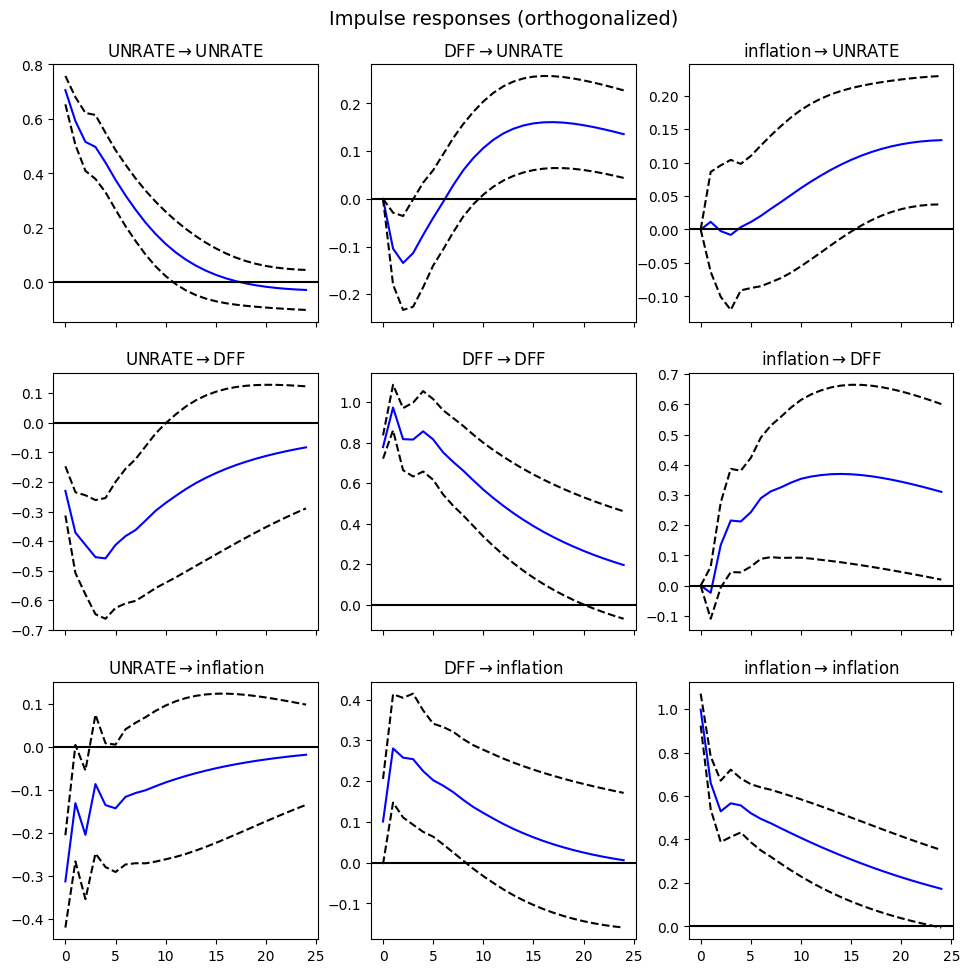

In [173]:
#Developing VAR model for full data from 1960-2023
model_full = VAR(dt)
results_full = model_full.fit(4)
irf = results_full.irf(24)
fig = irf.plot(orth=True,signif=0.1)

In [174]:
#Factor Error Variance Decompostion for the VAR model above
fevd_full = results_full.fevd(12)
fevd_full.summary()

FEVD for UNRATE
        UNRATE       DFF  inflation
0     1.000000  0.000000   0.000000
1     0.987157  0.012692   0.000151
2     0.974507  0.025374   0.000119
3     0.969955  0.029901   0.000144
4     0.970098  0.029768   0.000134
5     0.971566  0.028240   0.000194
6     0.972892  0.026701   0.000407
7     0.973002  0.026111   0.000887
8     0.971068  0.027219   0.001713
9     0.966736  0.030272   0.002992
10    0.959912  0.035277   0.004811
11    0.950728  0.042071   0.007202

FEVD for DFF
        UNRATE       DFF  inflation
0     0.080293  0.919707   0.000000
1     0.109154  0.890530   0.000316
2     0.138593  0.854249   0.007158
3     0.160988  0.820522   0.018490
4     0.172251  0.803331   0.024418
5     0.175215  0.793502   0.031283
6     0.176363  0.782869   0.040768
7     0.176825  0.772616   0.050560
8     0.175967  0.763881   0.060152
9     0.174241  0.755670   0.070089
10    0.172230  0.747502   0.080269
11    0.170077  0.739531   0.090392

FEVD for inflation
        UNRATE

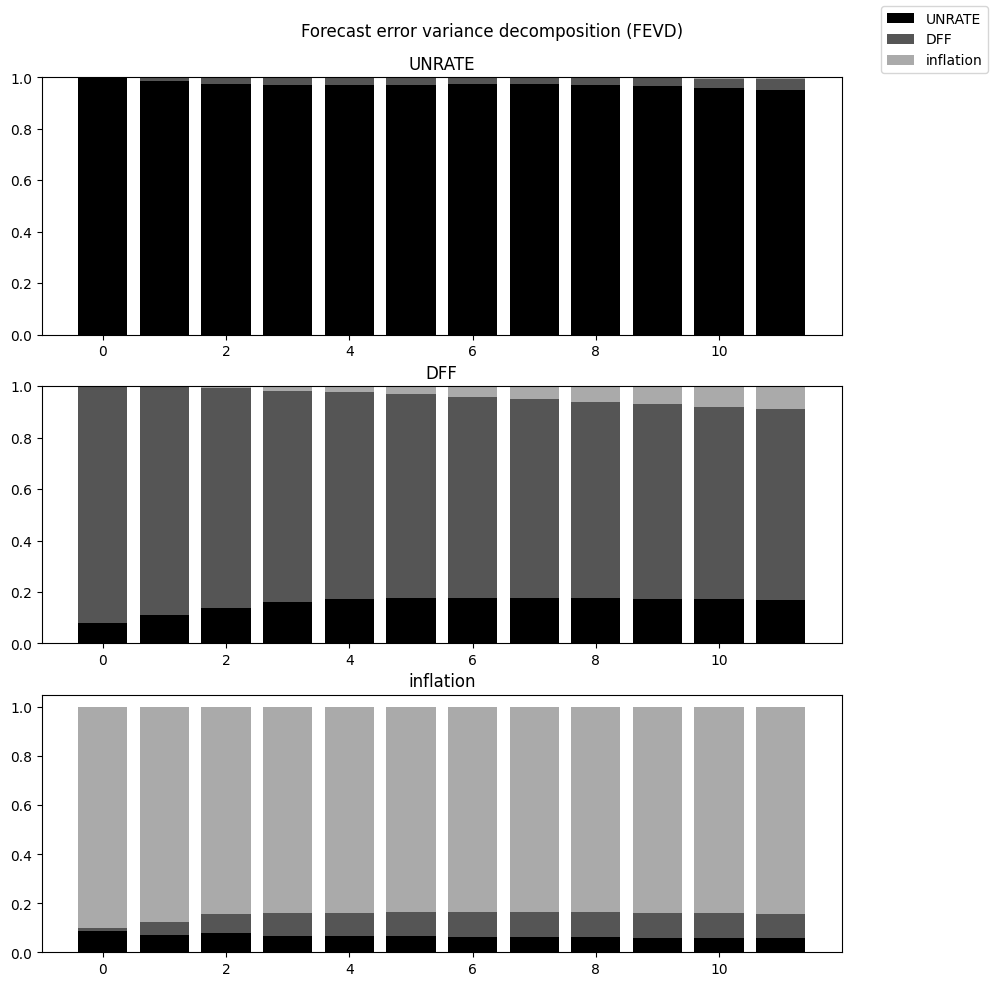

In [175]:
fevd_full.plot();

Testing for Granger Causality amongst variables for the full data from 1960 to 2023. 

In [177]:
results_full.test_causality('inflation', ['inflation'], kind='f').summary()

Test statistic,Critical value,p-value,df
131.8,2.385,0.000,"(4, 705)"


In [178]:
results_full.test_causality('UNRATE', ['UNRATE'], kind='f').summary()

Test statistic,Critical value,p-value,df
219.5,2.385,0.000,"(4, 705)"


In [179]:
results_full.test_causality('DFF', ['DFF'], kind='f').summary()

Test statistic,Critical value,p-value,df
604.3,2.385,0.000,"(4, 705)"


In [180]:
results_full.test_causality('inflation', ['UNRATE'], kind='f').summary()

Test statistic,Critical value,p-value,df
1.766,2.385,0.134,"(4, 705)"


In [181]:
results_full.test_causality('inflation', ['DFF'], kind='f').summary()

Test statistic,Critical value,p-value,df
2.913,2.385,0.021,"(4, 705)"


In [182]:
results_full.test_causality('UNRATE', ['inflation'], kind='f').summary()

Test statistic,Critical value,p-value,df
0.2926,2.385,0.883,"(4, 705)"


In [183]:
results_full.test_causality('UNRATE', ['DFF'], kind='f').summary()

Test statistic,Critical value,p-value,df
2.827,2.385,0.024,"(4, 705)"


In [184]:
results_full.test_causality('DFF', ['inflation'], kind='f').summary()

Test statistic,Critical value,p-value,df
3.419,2.385,0.009,"(4, 705)"


In [185]:
results_full.test_causality('DFF', ['UNRATE'], kind='f').summary()

Test statistic,Critical value,p-value,df
0.9567,2.385,0.431,"(4, 705)"
